In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['spam.csv']


In [4]:
import matplotlib.pyplot as plt

import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [5]:
data = pd.read_csv("../input/spam.csv", encoding = 'latin1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# unavailable
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [7]:
data = data.rename(columns ={"v1":"target", "v2":"text"})
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
data.target.value_counts()

ham     4825
spam     747
Name: target, dtype: int64

In [9]:
data.groupby('target').describe()

text                                                               
       count unique                                                top freq
target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

Text(0.5, 1.0, 'Distribution of Spam and Ham')

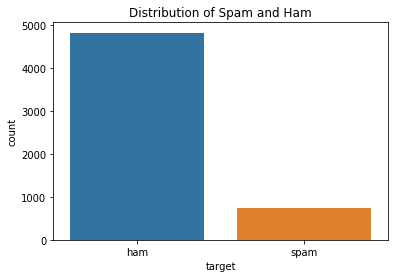

In [10]:
sns.countplot(x = "target", data = data)
data.loc[:, 'target'].value_counts()
plt.title('Distribution of Spam and Ham')

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


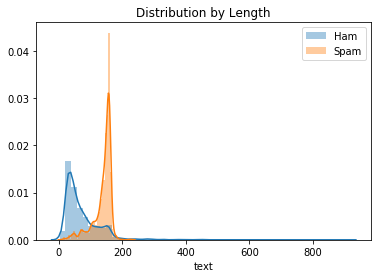

In [13]:
# graph by length
ham =data[data['target'] == 'ham']['text'].str.len()
sns.distplot(ham, label='Ham')
spam = data[data['target'] == 'spam']['text'].str.len()
sns.distplot(spam, label='Spam')
plt.title('Distribution by Length')
plt.legend()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


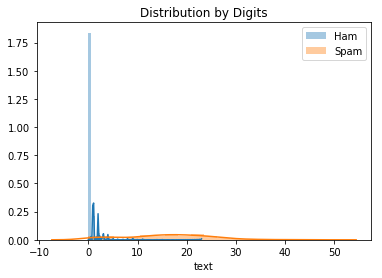

In [14]:
# graph by digits
ham1 = data[data['target'] == 'ham']['text'].str.replace(r'\D+', '').str.len()
sns.distplot(ham1, label='Ham')
spam1 = data[data['target'] == 'spam']['text'].str.replace(r'\D+', '').str.len()
sns.distplot(spam1, label='Spam')
plt.title('Distribution by Digits')
plt.legend()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


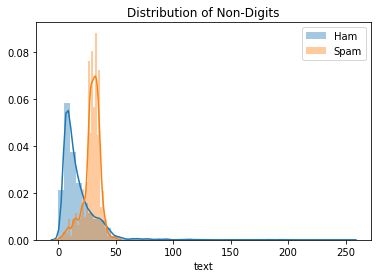

In [15]:
#graph by non-digits.

ham2 = data[data['target'] == 'ham']['text'].str.replace(r'\w+', '').str.len()
sns.distplot(ham2, label='Ham')
spam2 = data[data['target'] == 'spam']['text'].str.replace(r'\w+', '').str.len()
sns.distplot(spam2, label='Spam')
plt.title('Distribution of Non-Digits')
plt.legend()

In [16]:
count1 = Counter(" ".join(data[data['target']=='ham']["text"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of ham", 1 : "count"})
count2 = Counter(" ".join(data[data['target']=='spam']["text"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of spam", 1 : "count_"})

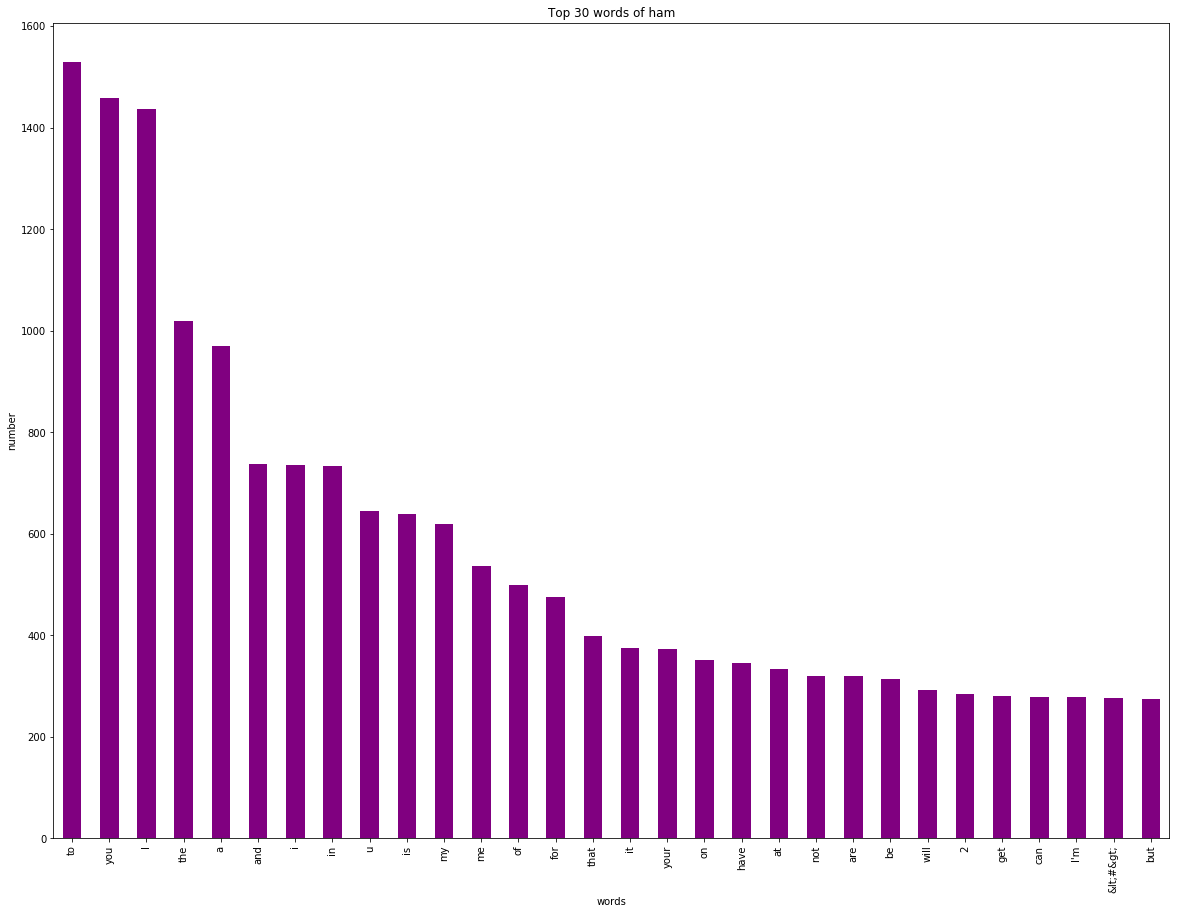

In [18]:
# top 30 ham
data1.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_pos = np.arange(len(data1["words of ham"]))
plt.xticks(y_pos, data1["words of ham"])
plt.title('Top 30 words of ham')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

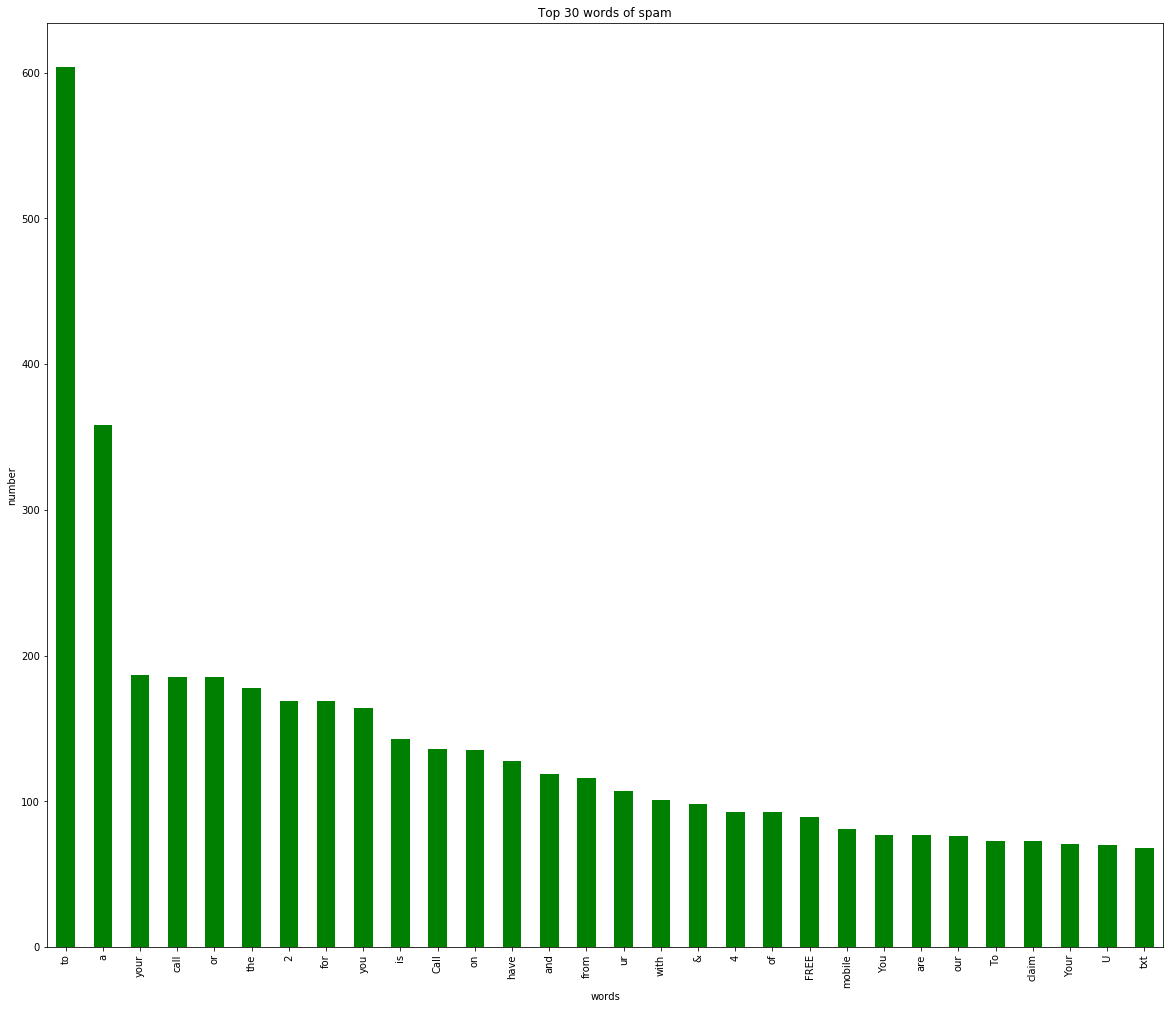

In [19]:
# top 30 spam
data2.plot.bar(legend = False, color = 'green', figsize = (20,17))
y_pos = np.arange(len(data2["words of spam"]))
plt.xticks(y_pos, data2["words of spam"])
plt.title('Top 30 words of spam')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size = 0.3, random_state = 37)
print ("X_train: ", len(X_train))
print("X_test: ", len(X_test))
print("y_train: ", len(y_train))
print("y_test: ", len(y_test))

X_train:  3900
X_test:  1672
y_train:  3900
y_test:  1672


In [23]:
corpus = []
for i in range(0, 5572):
    review = re.sub('[^a-zA-Z]', ' ', data['text'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [24]:
cv = CountVectorizer(max_features = 1500)
cv.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1500, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [25]:
X_train_cv = cv.transform(X_train)
X_train_cv

<3900x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 42787 stored elements in Compressed Sparse Row format>

In [26]:
X_test_cv = cv.transform(X_test)
X_test_cv

<1672x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 18639 stored elements in Compressed Sparse Row format>

In [27]:
# Naive Bayes
mnb = MultinomialNB(alpha = 0.5)
mnb.fit(X_train_cv,y_train)

y_mnb = mnb.predict(X_test_cv)

In [29]:
print('Naive Bayes Accuracy: ', accuracy_score( y_mnb , y_test))
print('Naive Bayes confusion_matrix: \n', confusion_matrix(y_mnb, y_test))

Naive Bayes Accuracy:  0.9826555023923444
Naive Bayes confusion_matrix: 
 [[1425   15]
 [  14  218]]


In [30]:
# KNN classification
knc = KNeighborsClassifier(n_neighbors=100)
knc.fit(X_train_cv,y_train)

y_knc = knc.predict(X_test_cv)

In [32]:
print('KNeighbors Accuracy_score: ',accuracy_score(y_test,y_knc))
print('KNeighbors confusion_matrix: \n', confusion_matrix(y_test, y_knc)) 

KNeighbors Accuracy_score:  0.8606459330143541
KNeighbors confusion_matrix: 
 [[1439    0]
 [ 233    0]]


In [33]:
#code ends